In [ ]:
import pandas as pd
import numpy as np
import re


In [ ]:
! pip install transformers
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# specify GPU
device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/project

/content/drive/MyDrive/project


In [ ]:
news = pd.read_csv('WELFake_Dataset_tes.csv')
news = news.drop(columns = ['Unnamed: 0'])
# See how the data looks like
print(news.shape)
news.head()

(37001, 4)


,Unnamed: 0.1,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
import re
def clean_txt(text1):
    text = re.sub("'", "", text1)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    return text
news = news.dropna()
news['text'] = news['text'].apply(clean_txt)
news.shape

(36725, 4)

In [ ]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
train_text, test_text, train_labels, test_labels = train_test_split(news['text'], news['label'],
                                                                    random_state=2018,
                                                                    test_size=0.15,
                                                                    stratify=news['label'])

In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
model.cuda()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [ ]:
model = torch.load('Fakefinal',map_location=torch.device("cuda"))


In [ ]:
# Majority of titles above have word length under 568. So, we set max title length as 270 sice bert max is 510 words and to save storage
MAX_LENGHT = 270

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

test_data = TensorDataset(test_seq, test_mask, test_y)            # wrap tensors
test_sampler = SequentialSampler(test_data)                     # sampler for sampling the data during training
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)



In [ ]:
predt = []
model.eval()
for step,batch in enumerate(test_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))
                                                  # Report progress
    batch = tuple(t.to(device) for t in batch)                   # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      preds = preds.detach().cpu().numpy()
    predt.extend(preds)

  Batch    50  of    173.
  Batch   100  of    173.
  Batch   150  of    173.


In [ ]:
test_mask.device

In [ ]:
print(classification_report(test_y, np.argmax(predt, axis = 1)))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2691
           1       0.83      0.81      0.82      2818

    accuracy                           0.82      5509
   macro avg       0.82      0.82      0.82      5509
weighted avg       0.82      0.82      0.82      5509



Confusion matrix, without normalization


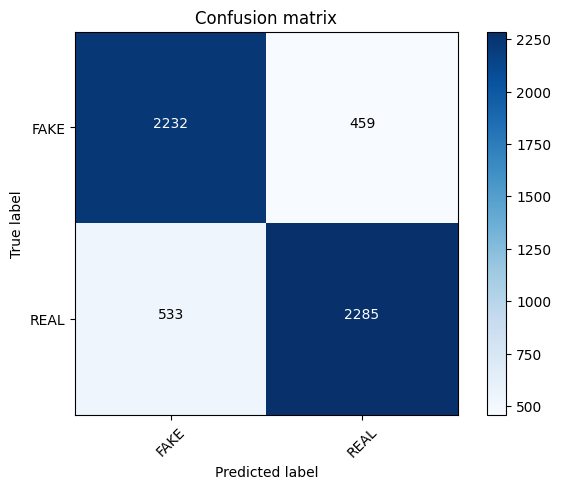

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(test_labels.tolist(), np.argmax(predt, axis = 1))
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
! pip install torch-summary
from torchsummary import summary

summary(model, input_size=(1, 512), depth=1, batch_dim=1, dtypes=[torch.long])

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         (109,482,240)
├─Dropout: 1-2                           --
├─ReLU: 1-3                              --
├─Linear: 1-4                            393,728
├─Linear: 1-5                            1,026
├─LogSoftmax: 1-6                        --
Total params: 109,876,994
Trainable params: 394,754
Non-trainable params: 109,482,240


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         (109,482,240)
├─Dropout: 1-2                           --
├─ReLU: 1-3                              --
├─Linear: 1-4                            393,728
├─Linear: 1-5                            1,026
├─LogSoftmax: 1-6                        --
Total params: 109,876,994
Trainable params: 394,754
Non-trainable params: 109,482,240

In [ ]:
print(model)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=